# 0.Set up libraries

In [2]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 29.5 MB/s 
     |████████████████████████████████| 3.3 MB 58.6 MB/s 
     |████████████████████████████████| 10.4 MB 41.5 MB/s 
     |████████████████████████████████| 137 kB 71.7 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 268 kB 68.6 MB/s 
     |████████████████████████████████| 636 kB 71.8 MB/s 
     |████████████████████████████████| 16.9 MB 46.2 MB/s 
     |████████████████████████████████| 167 kB 70.6 MB/s 
     |████████████████████████████████| 1.3 MB 44.6 MB/s 
     |████████████████████████████████| 6.8 MB 55.5 MB/s 
     |████████████████████████████████| 1.7 MB 51.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |██████████████████████████████

In [4]:
from pycaret.utils import enable_colab
enable_colab()
!pip install markupsafe==2.0.1
!pip uninstall NumPy --yes
!pip install NumPy==1.20

Colab mode enabled.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: numpy 1.20.0
Uninstalling numpy-1.20.0:
  Successfully uninstalled numpy-1.20.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.20.0-cp37-cp37m-manylinux2010_x86_64.whl (15.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.
en-core-web-sm 3.4.0 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.7 which is incompatible.
cmdstanpy 1.0.7 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.


In [1]:
# Restart runtime before ruuning this line of code
from pycaret.regression import *

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from datetime import datetime

In [3]:
# install shap
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 23.7 MB/s 


In [3]:
from numpy.core.fromnumeric import shape
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import time

In [4]:
from sklearn.ensemble import IsolationForest

# 1.Import data

In [5]:
# Some industrial data, any data will do
# read data and drop the first column
raw_test_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1jrv549VVFST4VcX1kFkXR8AdrT7MEOTI', 
                  sep=",", engine = "python").iloc[:, 1:]
raw_train_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1gU6xMwaSiF2h28kHrmtHUXgeK3zbonYW',  
                  sep=",", engine = "python").iloc[:, 1:]

In [6]:
# concatnate data
raw_dataset = pd.concat([raw_train_data,raw_test_data], ignore_index=True) 

print("Final raw data:", raw_dataset.shape)

Final raw data: (2086, 11)


In [7]:
import seaborn as sns

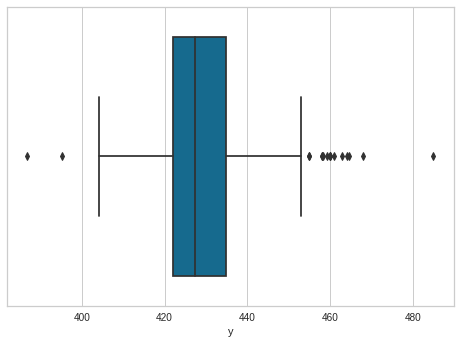

In [8]:
# Check data spread
sns.boxplot(x=raw_dataset['y'])

# 2.Remove outlier using Isolation Forest

In [9]:
data = raw_dataset.copy()

In [10]:
data.head(3)

,y,52TI766,52PI250,52FC231,52TI737,52FC1127,52TI878,52TI735,52FR235,52FC133,52FC1143
0,386.867188,364.803425,17.989441,5.226991,97.528902,5.728376,156.084524,339.257812,195.095252,4166.627155,1015.049214
1,461.000000,369.252009,17.956638,5.008640,101.321670,5.636113,156.463988,351.203598,189.323993,4318.935629,1024.531250
2,440.000000,396.190341,17.677898,4.349751,108.669922,6.681320,90.133937,368.427083,216.136332,4364.426647,1038.759577


In [11]:
model = IsolationForest(contamination=0.055, n_estimators=90, random_state=7)

In [12]:
model.fit(data)

IsolationForest(contamination=0.055, n_estimators=90, random_state=7)

In [13]:
data["iforest"] = pd.DataFrame(model.predict(data))
print(data["iforest"].value_counts())

 1    1971
-1     115
Name: iforest, dtype: int64


In [14]:
data_without_outliers = data[data["iforest"] == 1]
data_without_outliers.shape

(1971, 12)

In [15]:
Final_data = data_without_outliers.drop(["iforest"], axis = 1)
Final_data.shape

(1971, 11)

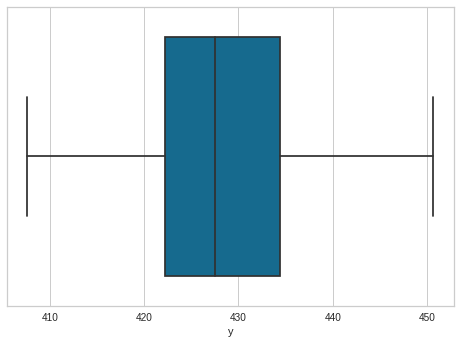

In [16]:
# Check data spread for outliers again
sns.boxplot(x=Final_data['y'])

In [17]:
x = Final_data.iloc[:, Final_data.columns != 'y']
y = Final_data['y']

In [18]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    Final_data.iloc[:, 1:],
    Final_data.iloc[:, 0:1],
    test_size=0.3,
    random_state=17)

# 3.Set up extra-trees regression model

In [19]:
et_2 = ExtraTreesRegressor(bootstrap= False, criterion= 'mse', 
                           max_depth= None, min_samples_leaf= 1, 
                           min_samples_split= 2, n_estimators= 300)

In [20]:
np.random.seed(17)
et_2.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=300)

In [21]:
et_2.score(X_train,y_train)

1.0

In [22]:
et_2.score(X_test,y_test)

0.8237091802390588

# 4.Explain the result of ET by Shap

In [23]:
x = Final_data.iloc[:, Final_data.columns != 'y']
y = Final_data['y']

In [24]:
et_2.fit(x, y)

ExtraTreesRegressor(n_estimators=300)

In [25]:
explainer = shap.Explainer(et_2)

In [29]:
shap_values = explainer.shap_values(x)

In [30]:
print("Our model's average prediction for our data set: ", explainer.expected_value)

Our model's average prediction for our data set:  [428.56102549]


## 1.Explain a single prediction

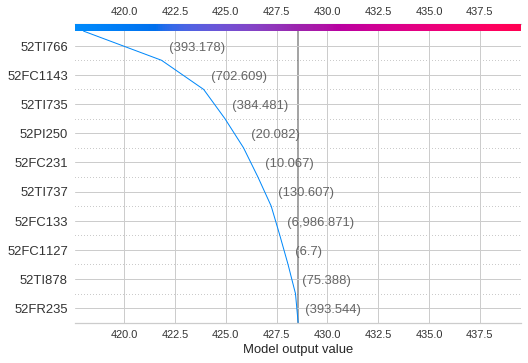

In [32]:
# visualization of how a single observation deviates from the average prediction

# randomly choose an observation
row = 777

# plot
shap.decision_plot(explainer.expected_value, shap_values[row, :], x.iloc[row, :])

## 2.Explain the entire dataset

In [33]:
# load JS visualization code to notebook
shap.initjs()

# plot
shap.plots.force(explainer.expected_value, shap_values)

## 3.Heatmap

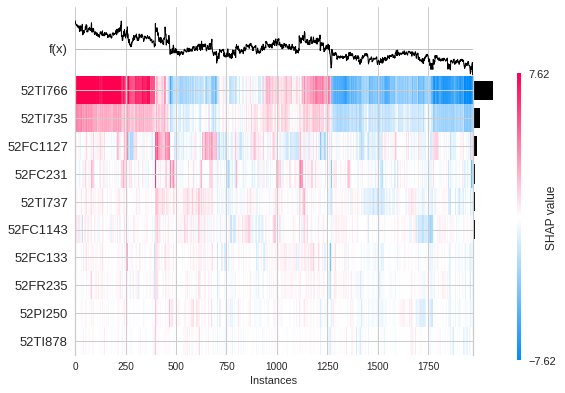

In [34]:
shap_values_explaination = shap.Explanation(shap_values, feature_names=x.columns.tolist()) 
shap.plots.heatmap(shap_values_explaination)

## 4.Feature importance summary

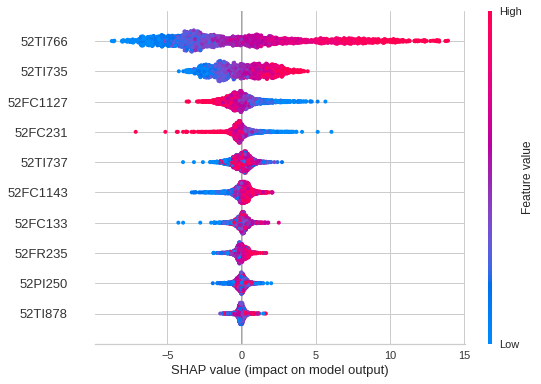

In [35]:
# a granular look at feature importances for the entire data set.
shap.summary_plot(shap_values, x)

## 5.Feature Interactions

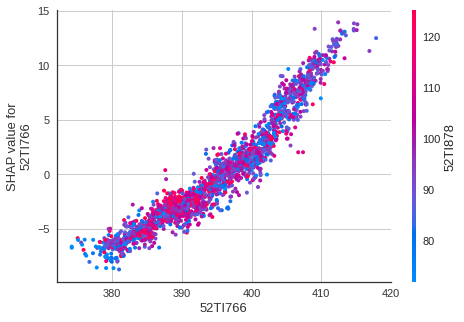

In [36]:
# load JS visualization code to notebook
shap.initjs()

# plot an example for "___" and "___"
shap.dependence_plot(0, shap_values, features=x, 
    interaction_index=5)

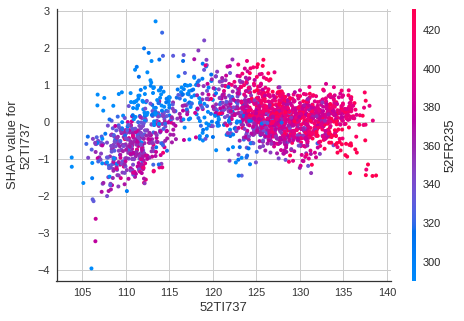

In [37]:
# load JS visualization code to notebook
shap.initjs()

# plot an example for "___" and "___"
shap.dependence_plot(3, shap_values, features=x, 
    interaction_index=7)